# Otimização de Portfólio com Scipy.Optimize

### Bibliotecas

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

## Introdução

A Teoria Moderna do Portfólio (Modelo de Média-Variância), baseia-se na ideias de que é possível criar portfólios que consigam obter maiores retornos esperados (média) a um menor nível de risco (volatilidade) por meio da diversificação. 

#### Volatilidade

A volatilidade de um portfólio com 2 ativos pode ser calculado como: 

$$
\sigma_p = \sqrt{w_A^2 \cdot \sigma_A^2 + w_B^2 \cdot \sigma_B^2 + 2 \cdot w_A \cdot w_B \cdot \rho_{AB} \cdot \sigma_A \cdot \sigma_B}
$$

Onde:

$w = \text{pesos}$ <br>
$\sigma = \text{volatilidade}$ <br>
$\rho = \text{correlação}$

Matricialmente pode ser calculado como:

$$
\sigma_p^2 = w^T \cdot \Sigma \cdot w
$$

Onde: 

$\Sigma = \text{matriz de covariância}$

#### Retorno Esperado

O retorno de um portfólio com 2 ativos pode ser calculado como: 

$$
r_p = w_A \cdot r_A + w_B \cdot r_B
$$

Matricialmente pode ser calculado como:

$$
r_p = w^T \cdot r
$$

Onde:

$r = \text{vetor de retornos}$

#### Fronteira Eficiente

A fronteira eficiente representa todos os portfólios que forneçam a melhor relação de risco e retorno sujeito a restrição que a soma dos pesos deve ser igual a 1 e o retorno deve ser igual ao retorno alvo (target return). Pode ser representado pelo problema de otimização abaixo: 

$$
\min_{w} \quad \sqrt{w^T \Sigma w}
$$

Sujeito a:

$$
w^T \cdot r = r_{\text{target}}
$$

$$
w^T \cdot 1 = 1
$$

## Extração e Tratamento dos Dados

A volatilidade, covariância e retorno esperado podem ser estimados a partir dos retornos históricos dos ativos, foi considerado uma janela de 3 anos e os ativos foram escolhidos arbitrariamente. 

In [13]:
tickers = ['PETR4.SA', 'MRFG3.SA','ITUB3.SA','WEGE3.SA']

data = pd.DataFrame()

for t in tickers:
    data[t] = yf.download(t, start='2022-01-01',end='2025-01-01', progress=False)['Close']

data

YF.download() has changed argument auto_adjust default to True


,PETR4.SA,MRFG3.SA,ITUB3.SA,WEGE3.SA
Date,,,,
2022-01-03,11.470977,14.394269,14.397235,30.170816
2022-01-04,11.514353,14.556684,14.716680,30.020061
2022-01-05,11.068762,14.441640,14.419521,28.437078
2022-01-06,11.060876,14.441640,14.679538,28.427662
2022-01-07,11.112138,14.326594,14.909829,27.711548
...,...,...,...,...
2024-12-20,35.493477,16.799999,24.677567,55.020622
2024-12-23,35.503109,16.660000,24.247458,53.810059
2024-12-26,35.770000,16.830000,24.372906,54.226730


### Retorno Acumulado

<Axes: xlabel='Date'>

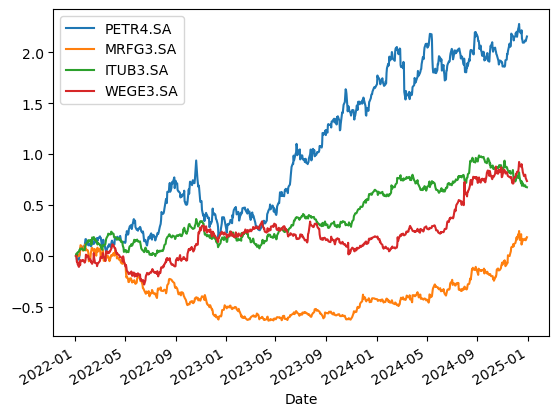

In [15]:
rac_data = data/data.iloc[0]-1
rac_data.plot()

### Retorno Diário

In [17]:
rd_data = data.pct_change().dropna()

rd_data.describe()

,PETR4.SA,MRFG3.SA,ITUB3.SA,WEGE3.SA
count,748.000000,748.000000,748.000000,748.000000
mean,0.001761,0.000623,0.000774,0.000912
std,0.021100,0.028338,0.013025,0.018788
min,-0.091994,-0.090762,-0.050963,-0.101114
25%,-0.009242,-0.016552,-0.006793,-0.009371
50%,0.001390,0.000000,0.000421,-0.000265
75%,0.014035,0.016730,0.008349,0.010396
max,0.079866,0.131885,0.065474,0.104666


<Axes: >

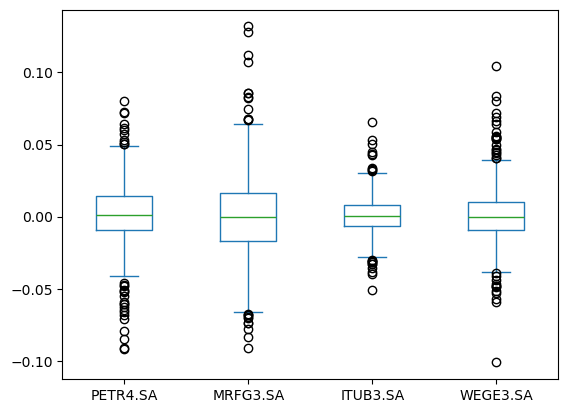

In [18]:
rd_data.plot(kind='box')

### Matriz de Correlação

<Axes: >

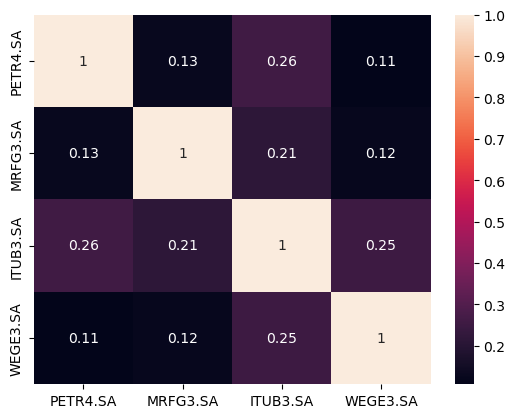

In [20]:
corr_matrix = rd_data.corr()
sns.heatmap(corr_matrix, annot=True)

### Matriz de Covariância

In [22]:
cov_matrix = rd_data.cov()
cov_matrix

,PETR4.SA,MRFG3.SA,ITUB3.SA,WEGE3.SA
PETR4.SA,0.000445,0.000076,0.000071,0.000043
MRFG3.SA,0.000076,0.000803,0.000079,0.000065
ITUB3.SA,0.000071,0.000079,0.000170,0.000062
WEGE3.SA,0.000043,0.000065,0.000062,0.000353


### Retornos Esperados

In [24]:
expected_return = rd_data.mean()
expected_return

PETR4.SA    0.001761
MRFG3.SA    0.000623
ITUB3.SA    0.000774
WEGE3.SA    0.000912
dtype: float64

## Simulação de Portfólios

In [63]:
num_portfolios = 1000

results = np.zeros((3, num_portfolios))
results

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights = np.round(weights/np.sum(weights),4)
    
    portfolio_return = np.sum(weights * expected_return)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility

portfolio_results = pd.DataFrame(results.T, columns=['Retorno', 'Volatilidade', 'Sharpe'])
portfolio_results.tail()

,Retorno,Volatilidade,Sharpe
995,0.001100,0.012249,0.089817
996,0.000945,0.013436,0.070361
997,0.001200,0.012934,0.092784
998,0.001170,0.014097,0.082991
999,0.001193,0.013569,0.087928


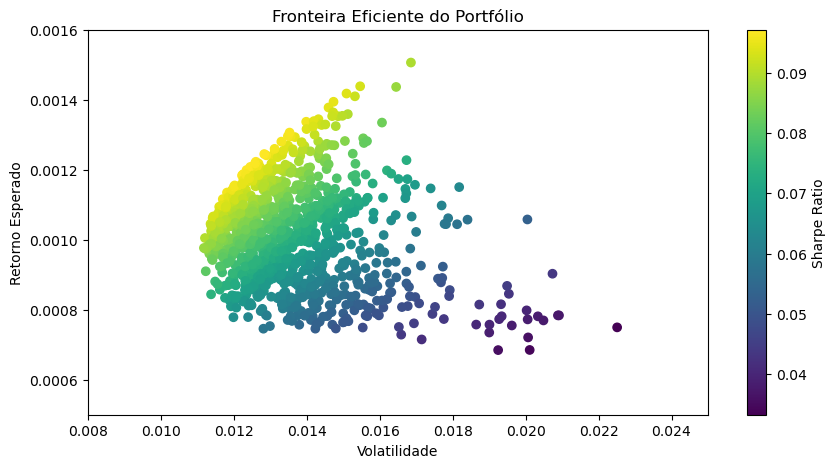

In [79]:
plt.figure(figsize=(10, 5))

plt.scatter(portfolio_results.Volatilidade, portfolio_results.Retorno, c=portfolio_results.Sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira Eficiente do Portfólio')

plt.xlim(0.008, 0.025)
plt.ylim(0.0005, 0.0016)

plt.show()

## Fronteira Eficiente

A Fronteira Eficiente pode ser projetada minimizando a volatilidade para um dado nível de retorno (target return) considerando que a soma dos pesos deve dar 1. Esse problema pode ser resolvido com a função minimize da biblioteca scipy.optimize:

minimize(fun, x0, args=(), method=None, bounds=None, constraints=())

- fun: Função objetivo.
- x0: Ponto inicial para a otimização.
- args: Argumentos da função objetivo.
- method: Método de otimização.
- bounds: Limites para as variáveis.
- constraints: Restrições do problema.

Link: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [68]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def min_volatility_for_return(target_return, expected_return, cov_matrix):
    num_assets = len(expected_return)
    args = cov_matrix
    
    # Função objetivo
    def objective(weights, expected_return, cov_matrix, target_return):
        return portfolio_volatility(weights, cov_matrix)

    # Restrições (Constraints): soma dos pesos = 1 e retorno do portfólio = target_return
    cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'eq', 'fun': lambda weights: np.sum(weights * expected_return) - target_return})
    
    # Limite de pesos para os ativos (0 a 1)
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    # Inicialização dos pesos
    initial_weights = num_assets * [1 / num_assets]
    
    # Otimização (Minizar a volatilidade)
    result = minimize(objective, initial_weights, args=(expected_return, cov_matrix, target_return), 
                      method='SLSQP', bounds=bounds, constraints=cons)
    
    return result.x

In [81]:
target_returns = np.linspace(min(expected_return), max(expected_return), 100)
efficient_frontier = []

for tr in target_returns:
    weights = np.round(min_volatility_for_return(tr, expected_return, cov_matrix),4)
    vol = portfolio_volatility(weights, cov_matrix)
    sharpe = (tr-0.00052)/vol
    efficient_frontier.append([tr, vol, sharpe, weights])

efficient_frontier = pd.DataFrame(efficient_frontier, columns=['Retorno','Volatilidade','Sharpe','Pesos'])
efficient_frontier = efficient_frontier[efficient_frontier['Retorno'] > efficient_frontier.loc[efficient_frontier['Volatilidade'].idxmin()]['Retorno']]
efficient_frontier.head()

,Retorno,Volatilidade,Sharpe,Pesos
30,0.000968,0.011142,0.040210,"[0.1753, 0.0635, 0.5385, 0.2227]"
31,0.000980,0.011155,0.041195,"[0.1866, 0.0613, 0.5293, 0.2229]"
32,0.000991,0.011171,0.042162,"[0.1979, 0.0592, 0.5199, 0.2231]"
33,0.001003,0.011191,0.043114,"[0.2091, 0.0569, 0.5102, 0.2237]"
34,0.001014,0.011220,0.044029,"[0.2206, 0.0549, 0.5017, 0.2228]"


### Portfólios Ótimos e CAL

Abaixo temos os portfólios com menor volatilidade, maior retorno e maior índice sharpe. Para o cálculo do sharpe foi considerado uma taxa de juros (risk-free rate) de 12% a.a que foi trazido para base diária. 

A CAL (Capital Allocation Line) representa os portfólios que podem ser obtidos combinando o ativo livre de risco com o portfólio escolhido. 

#### Taxa Livre de Risco

In [83]:
rf_rate = 1.12**(1/252)-1
rf_rate

0.0004498181430394599

#### Portfólio de mínima volatilidade

In [86]:
x = np.linspace(0,3,101)
x_inv = 1-np.linspace(0,3,101)

x

array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
       0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
       0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
       0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
       1.32, 1.35, 1.38, 1.41, 1.44, 1.47, 1.5 , 1.53, 1.56, 1.59, 1.62,
       1.65, 1.68, 1.71, 1.74, 1.77, 1.8 , 1.83, 1.86, 1.89, 1.92, 1.95,
       1.98, 2.01, 2.04, 2.07, 2.1 , 2.13, 2.16, 2.19, 2.22, 2.25, 2.28,
       2.31, 2.34, 2.37, 2.4 , 2.43, 2.46, 2.49, 2.52, 2.55, 2.58, 2.61,
       2.64, 2.67, 2.7 , 2.73, 2.76, 2.79, 2.82, 2.85, 2.88, 2.91, 2.94,
       2.97, 3.  ])

In [88]:
portfolio_min_vol = efficient_frontier.loc[efficient_frontier['Volatilidade'].idxmin()]
CAL_min_vol = pd.DataFrame({'Retorno':portfolio_min_vol['Retorno'] * x + rf_rate * x_inv,
                            'Volatilidade':portfolio_min_vol['Volatilidade'] * x})

portfolio_min_vol

Retorno                                 0.000968
Volatilidade                            0.011142
Sharpe                                   0.04021
Pesos           [0.1753, 0.0635, 0.5385, 0.2227]
Name: 30, dtype: object

#### Portfólio de Máximo Sharpe

In [91]:
portfolio_max_sharpe = efficient_frontier.loc[efficient_frontier['Sharpe'].idxmax()]
CAL_max_sharpe = pd.DataFrame({'Retorno':portfolio_max_sharpe['Retorno']*x + rf_rate * x_inv,
                               'Volatilidade':portfolio_max_sharpe['Volatilidade'] * x})

portfolio_max_sharpe

Retorno                           0.001577
Volatilidade                      0.017442
Sharpe                             0.06059
Pesos           [0.7834, 0.0, 0.0, 0.2166]
Name: 83, dtype: object

#### Portfólio de Maior Retorno

In [94]:
portfolio_max_return = efficient_frontier.loc[efficient_frontier['Retorno'].idxmax()]
CAL_max_return = pd.DataFrame({'Retorno':portfolio_max_return['Retorno'] * x + rf_rate * x_inv,
                               'Volatilidade':portfolio_max_return['Volatilidade'] * x})

portfolio_max_return

Retorno                     0.001761
Volatilidade                  0.0211
Sharpe                      0.058796
Pesos           [1.0, 0.0, 0.0, 0.0]
Name: 99, dtype: object

### Gráfico Fronteira Eficiente

É possível observar que o portfólio com o maior índice sharpe oferece a melhor relação de risco e retorno a qualquer volatilidade ao incluir um ativo de livre-risco. 

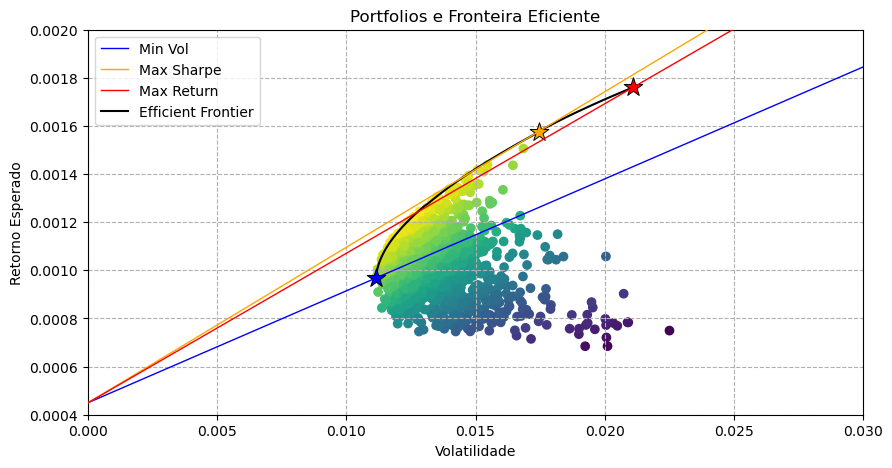

In [101]:
plt.figure(figsize=(10, 5))

plt.scatter(portfolio_min_vol['Volatilidade'], portfolio_min_vol['Retorno'], 
            c='blue', edgecolors='black', s=200, marker='*', linewidths=0.7, zorder=3)
plt.scatter(portfolio_max_sharpe['Volatilidade'], portfolio_max_sharpe['Retorno'], 
            c='orange', edgecolors='black', s=200, marker='*', linewidths=0.7, zorder=3)
plt.scatter(portfolio_max_return['Volatilidade'], portfolio_max_return['Retorno'], 
            c='red', edgecolors='black', s=200, marker='*', linewidths=0.7, zorder=3)

plt.plot(CAL_min_vol['Volatilidade'], CAL_min_vol['Retorno'], c='blue', label='Min Vol', linewidth=1, zorder=3)
plt.plot(CAL_max_sharpe['Volatilidade'], CAL_max_sharpe['Retorno'], c='orange', label='Max Sharpe', linewidth=1, zorder=3)
plt.plot(CAL_max_return['Volatilidade'], CAL_max_return['Retorno'], c='red', label='Max Return', linewidth=1, zorder=3)

plt.plot(efficient_frontier['Volatilidade'], efficient_frontier['Retorno'], color='black', label='Efficient Frontier')
plt.scatter(portfolio_results['Volatilidade'], portfolio_results['Retorno'], c=portfolio_results['Sharpe'], cmap='viridis')

plt.xlabel('Volatilidade')
plt.ylabel('Retorno Esperado')
plt.title('Portfolios e Fronteira Eficiente')

plt.xlim(0.0, 0.03)
plt.ylim(0.0004, 0.002)

plt.legend()
plt.grid(linestyle='dashed')
plt.show()

### Retornos Acumulados

In [104]:
optimal_portfolios = pd.DataFrame()

for i in range(len(efficient_frontier['Pesos'])):
    optimal_portfolios[i] = (efficient_frontier['Pesos'].to_numpy()[i] * rac_data).sum(axis=1)

optimal_portfolios.tail()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-20,0.945665,0.962557,0.979324,0.995962,1.012900,1.029539,1.046370,1.063594,1.080190,1.097198,...,1.939411,1.956597,1.973749,1.991029,2.008181,2.025334,2.042614,2.059766,2.077046,2.094198
2024-12-23,0.920172,0.937362,0.954431,0.971367,0.988624,1.005562,1.022685,1.040188,1.057093,1.074394,...,1.935264,1.953000,1.970705,1.988542,2.006248,2.023953,2.041790,2.059496,2.077332,2.095038
2024-12-26,0.932768,0.950118,0.967345,0.984439,1.001854,1.018949,1.036227,1.053884,1.070949,1.088409,...,1.957378,1.975242,1.993076,2.011041,2.028874,2.046708,2.064673,2.082506,2.100471,2.118305
2024-12-27,0.914517,0.931930,0.949223,0.966377,0.983875,1.001034,1.018378,1.036101,1.053231,1.070755,...,1.945036,1.963202,1.981340,1.999614,2.017752,2.035891,2.054164,2.072303,2.090576,2.108715
2024-12-30,0.916174,0.934066,0.951842,0.969457,0.987480,1.005113,1.022919,1.041092,1.058708,1.076711,...,1.981976,2.001161,2.020327,2.039636,2.058802,2.077969,2.097277,2.116444,2.135752,2.154919


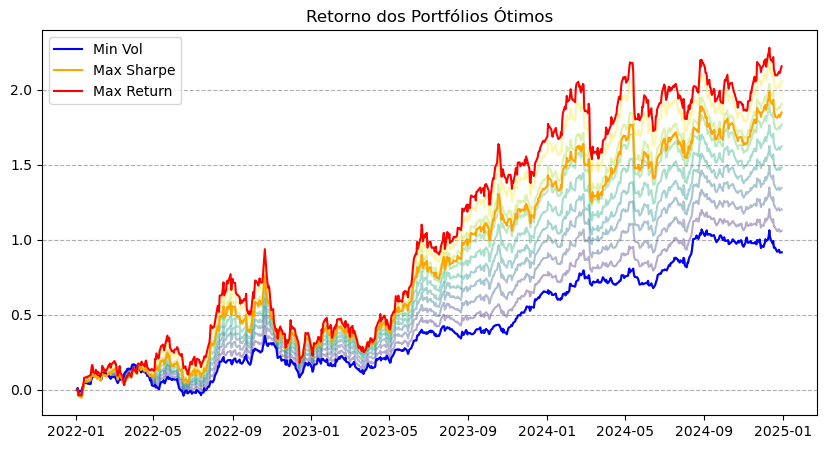

In [108]:
plt.figure(figsize=(10,5))
plt.title("Retorno dos Portfólios Ótimos")

cols = optimal_portfolios.iloc[:, ::8].columns
colors = plt.cm.viridis(np.linspace(0, 1, len(cols)))

for i, col in enumerate(cols):
    plt.plot(optimal_portfolios.index, optimal_portfolios[col], color=colors[i], alpha=0.4)

# Portfólios 
rac_min_vol = np.sum(portfolio_min_vol['Pesos'] * rac_data, axis=1)
rac_max_sharpe = np.sum(portfolio_max_sharpe['Pesos'] * rac_data, axis=1)
rac_max_return = np.sum(portfolio_max_return['Pesos'] * rac_data, axis=1)

plt.plot(rac_min_vol, c='blue', label='Min Vol')
plt.plot(rac_max_sharpe, c='orange', label='Max Sharpe')
plt.plot(rac_max_return, c='red', label='Max Return')

plt.grid(axis='y', linestyle='dashed')
plt.legend()
plt.show()

In [109]:
pd.DataFrame({"Min Vol":(1+rac_min_vol).pct_change().describe(),
              "Max Sharpe":(1+rac_max_sharpe).pct_change().describe(),
              "Max Return":(1+rac_max_return).pct_change().describe()})

,Min Vol,Max Sharpe,Max Return
count,748.000000,748.000000,748.000000
mean,0.000933,0.001569,0.001761
std,0.011230,0.018348,0.021100
min,-0.042335,-0.081832,-0.091994
25%,-0.005438,-0.008163,-0.009242
50%,0.000924,0.001430,0.001390
75%,0.008004,0.012347,0.014035
max,0.056565,0.074409,0.079866


### Bibliografia

Fundamentos dos Investimentos, BKM